In [1]:
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # specify the path of the folder containing "file_name" :
    path_to_file = '/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/
/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data


In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(221)

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model
import math
import prediction_prep as prep

import warnings
warnings.filterwarnings('ignore')

## Load in Data

In [3]:
# READ IN ALL DATA
ticker = 'NOK'
comments = pd.read_csv('comments_preprocessed_assigned.csv')
sentiment = pd.read_csv('df_pred_id_body.csv')
# fin_data = pd.read_csv(r'C:\Users\Nylle\`Assignments\LSTM\Stock\AMC_2021.csv')
fin_data = pd.read_csv('stock_data/{}_2021.csv'.format(ticker))

# Call custom function to get concatenated df with all features
df = prep.get_regression_df(ticker_name = str.lower(ticker),
                           comments = comments, 
                           fin_data = fin_data,
                           sentiment = sentiment)

# Set up a results dictionary object
results_dict = {}

df.head()

,date,comments_neutral,comments_positive,comment_count,pct_pos_comments,is_meme,comments_neutral_rollsum_2D,comments_neutral_rollmean_2D,comments_neutral_2D_pctchg,comments_positive_rollsum_2D,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log
0,2021-01-01,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
1,2021-01-02,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
2,2021-01-03,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
3,2021-01-04,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.640602,0,-0.445346
4,2021-01-05,0.0,0.0,0.0,0.0,0,0.0,0.0,NaN,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.993208,1,-0.006816


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 100 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           366 non-null    datetime64[ns]
 1   comments_neutral               366 non-null    float64       
 2   comments_positive              366 non-null    float64       
 3   comment_count                  366 non-null    float64       
 4   pct_pos_comments               366 non-null    float64       
 5   is_meme                        366 non-null    int64         
 6   comments_neutral_rollsum_2D    365 non-null    float64       
 7   comments_neutral_rollmean_2D   365 non-null    float64       
 8   comments_neutral_2D_pctchg     205 non-null    float64       
 9   comments_positive_rollsum_2D   365 non-null    float64       
 10  comments_positive_rollmean_2D  365 non-null    float64       
 11  comments_positive_

## LSTM: CLOSE PRICE WITH SENTIMENT

### 1-Day Shift

In [5]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Low', 'Volume', 'SD_log', 'Dir', '2D%Change', '7D%Change', '5Dir', 'Open', '4D%Change', 'Daily%Change', '6Dir', '4Dir', '3Dir', '7Dir', '2Dir', '3D%Change', '5D%Change', 'High', 'SD', '6D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,4Dir(t-1),3Dir(t-1),7Dir(t-1),2Dir(t-1),3D%Change(t-1),5D%Change(t-1),High(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
11,4.20,2,3.0,1.0,4.0,24.999375,3.0,1.5,50.000000,2.0,...,1.0,1.0,1.0,1.0,3.768847,6.718352,4.19,1.247917,5.089060,4.13
12,4.22,3,38.0,23.0,61.0,37.704856,41.0,20.5,100.000000,24.0,...,1.0,1.0,1.0,1.0,2.689478,4.738144,4.23,0.822854,8.527130,4.20
13,4.20,4,55.0,29.0,84.0,34.523768,93.0,46.5,1733.333333,52.0,...,1.0,1.0,1.0,1.0,3.431369,6.030145,4.23,0.180956,5.236896,4.22
14,4.85,0,215.0,104.0,319.0,32.601871,274.0,137.0,834.782609,143.0,...,1.0,1.0,1.0,0.0,1.694908,2.689478,4.22,0.748249,5.527633,4.20
16,6.55,2,0.0,0.0,0.0,0.000000,0.0,0.0,-100.000000,0.0,...,1.0,1.0,1.0,1.0,12.085314,14.527842,5.27,1.531306,15.931375,4.73


In [6]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-1)', 'comments_positive(t-1)', 'comment_count(t-1)', 'pct_pos_comments(t-1)', 'comments_neutral_rollsum_2D(t-1)', 'comments_neutral_rollmean_2D(t-1)', 'comments_neutral_2D_pctchg(t-1)', 'comments_positive_rollsum_2D(t-1)', 'comments_positive_rollmean_2D(t-1)', 'comments_positive_2D_pctchg(t-1)', 'comment_count_rollsum_2D(t-1)', 'comment_count_rollmean_2D(t-1)', 'comment_count_2D_pctchg(t-1)', 'pct_pos_comments_rollsum_2D(t-1)', 'pct_pos_comments_rollmean_2D(t-1)', 'pct_pos_comments_2D_pctchg(t-1)', 'comments_neutral_rollsum_3D(t-1)', 'comments_neutral_rollmean_3D(t-1)', 'comments_neutral_3D_pctchg(t-1)', 'comments_positive_rollsum_3D(t-1)', 'comments_positive_rollmean_3D(t-1)', 'comments_positive_3D_pctchg(t-1)', 'comment_count_rollsum_3D(t-1)', 'comment_count_rollmean_3D(t-1)', 'comment_count_3D_pctchg(t-1)', 'pct_pos_comments_rollsum_3D(t-1)', 'pct_pos_comments_rollmean_3D(t-1)', 'pct_pos_comments_3D_pctchg(t-1)', 'comments_ne

,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,4Dir(t-1),3Dir(t-1),7Dir(t-1),2Dir(t-1),3D%Change(t-1),5D%Change(t-1),High(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
182,5.58,3,2.0,2.0,4.0,49.998750,3.0,1.5,-81.818182,2.0,...,0.0,1.0,0.0,1.0,1.090908,-0.891269,5.62,1.135011,-3.472227,5.56
183,5.58,4,1.0,1.0,2.0,49.997500,3.0,1.5,0.000000,3.0,...,1.0,1.0,0.0,1.0,4.299066,-0.711743,5.62,0.482555,-0.534763,5.58
189,5.47,0,2.0,2.0,4.0,49.998750,2.0,1.0,100.000000,2.0,...,0.0,1.0,0.0,1.0,0.552490,-2.150536,5.51,0.437833,-2.150536,5.46
223,5.81,4,2.0,1.0,3.0,33.332222,2.0,1.0,100.000000,3.0,...,1.0,1.0,1.0,1.0,4.293377,2.101574,5.84,0.785859,2.280704,5.83
227,5.55,4,1.0,1.0,2.0,49.997500,2.0,1.0,100.000000,2.0,...,0.0,0.0,1.0,1.0,-0.860580,1.408458,5.78,0.318107,3.041146,5.76


In [7]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(61, 100)
(22, 100)


In [8]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(54, 7, 99) (54,)
(15, 7, 99) (15,)
0.0
0.3919413305205184


In [9]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

693 7 99


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 0.6932
Epoch 1: val_loss improved from inf to 0.49698, saving model to NOK_Close_1shift_Sentiment.h5
4/4 [==============================] - 7s 773ms/step - loss: 0.6932 - val_loss: 0.4970
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 0.1119
Epoch 2: val_loss improved from 0.49698 to 0.02686, saving model to NOK_Close_1shift_Sentiment.h5
4/4 [==============================] - 2s 414ms/step - loss: 0.1119 - val_loss: 0.0269
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 0.0558
Epoch 3: val_loss did not improve from 0.02686
4/4 [==============================] - 1s 311ms/step - loss: 0.0558 - val_loss: 0.0914
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 0.0335
Epoch 4: val_loss did not improve from 0.02686
4/4 [==============================] - 1s 307ms/step - loss: 0.0335 - val_loss: 0.0911
Epoch 5/100
4/4 [==============================] - ETA: 0s - loss: 0.0

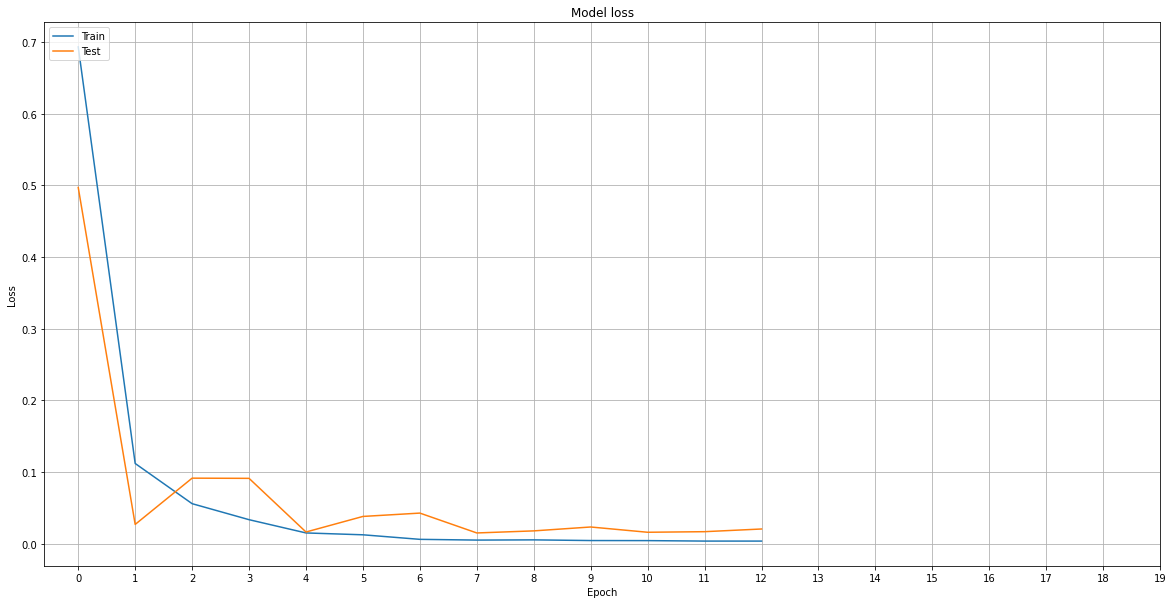

In [11]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [12]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list
results

Median Absolute Error (MAE): 0.29
Mean Absolute Percentage Error (MAPE): 5.04 %
Median Absolute Percentage Error (MDAPE): 4.11 %


,MAE,MAPE,MDAPE
0,0.287605,5.037762,4.107401


In [13]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

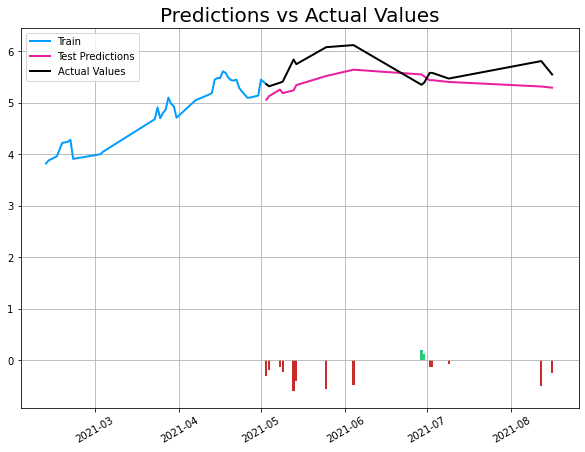

In [14]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 4-Day Shift

In [15]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Low', 'Volume', 'SD_log', 'Dir', '2D%Change', '7D%Change', '5Dir', 'Open', '4D%Change', 'Daily%Change', '6Dir', '4Dir', '3Dir', '7Dir', '2Dir', '3D%Change', '5D%Change', 'High', 'SD', '6D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,4Dir(t-4),3Dir(t-4),7Dir(t-4),2Dir(t-4),3D%Change(t-4),5D%Change(t-4),High(t-4),SD(t-4),6D%Change(t-4),Close(t-4)
10,4.13,1,9.0,14.0,23.0,60.869301,10.0,5.0,100.000000,14.0,...,0.0,1.0,1.0,1.0,0.501259,-0.742568,4.02,0.930101,3.084836,4.01
11,4.20,2,2.0,2.0,4.0,49.998750,11.0,5.5,100.000000,16.0,...,0.0,1.0,1.0,1.0,1.272263,-1.485147,3.98,0.696090,-1.485147,3.98
14,4.85,0,55.0,29.0,84.0,34.523768,93.0,46.5,1733.333333,52.0,...,1.0,1.0,1.0,1.0,3.768847,6.718352,4.19,1.247917,5.089060,4.13
15,4.73,1,23.0,9.0,32.0,28.124912,78.0,39.0,-39.473684,38.0,...,1.0,1.0,1.0,1.0,2.689478,4.738144,4.23,0.822854,8.527130,4.20
16,6.55,2,59.0,39.0,98.0,39.795878,82.0,41.0,7.272727,48.0,...,1.0,1.0,1.0,1.0,3.431369,6.030145,4.23,0.180956,5.236896,4.22


In [16]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-4)', 'comments_positive(t-4)', 'comment_count(t-4)', 'pct_pos_comments(t-4)', 'comments_neutral_rollsum_2D(t-4)', 'comments_neutral_rollmean_2D(t-4)', 'comments_neutral_2D_pctchg(t-4)', 'comments_positive_rollsum_2D(t-4)', 'comments_positive_rollmean_2D(t-4)', 'comments_positive_2D_pctchg(t-4)', 'comment_count_rollsum_2D(t-4)', 'comment_count_rollmean_2D(t-4)', 'comment_count_2D_pctchg(t-4)', 'pct_pos_comments_rollsum_2D(t-4)', 'pct_pos_comments_rollmean_2D(t-4)', 'pct_pos_comments_2D_pctchg(t-4)', 'comments_neutral_rollsum_3D(t-4)', 'comments_neutral_rollmean_3D(t-4)', 'comments_neutral_3D_pctchg(t-4)', 'comments_positive_rollsum_3D(t-4)', 'comments_positive_rollmean_3D(t-4)', 'comments_positive_3D_pctchg(t-4)', 'comment_count_rollsum_3D(t-4)', 'comment_count_rollmean_3D(t-4)', 'comment_count_3D_pctchg(t-4)', 'pct_pos_comments_rollsum_3D(t-4)', 'pct_pos_comments_rollmean_3D(t-4)', 'pct_pos_comments_3D_pctchg(t-4)', 'comments_ne

,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,4Dir(t-4),3Dir(t-4),7Dir(t-4),2Dir(t-4),3D%Change(t-4),5D%Change(t-4),High(t-4),SD(t-4),6D%Change(t-4),Close(t-4)
183,5.58,4,11.0,9.0,20.0,44.999775,35.0,17.5,100.0,19.0,...,0.0,0.0,0.0,0.0,-4.634585,-7.118061,5.44,1.179067,-8.233277,5.35
184,5.63,0,1.0,1.0,2.0,49.997500,3.0,1.5,0.0,3.0,...,0.0,0.0,0.0,0.0,-4.092527,-6.423617,5.48,0.567534,-6.423617,5.39
192,5.77,3,2.0,2.0,4.0,49.998750,2.0,1.0,100.0,2.0,...,0.0,1.0,0.0,1.0,0.552490,-2.150536,5.51,0.437833,-2.150536,5.46
224,5.68,0,2.0,1.0,3.0,33.332222,2.0,1.0,100.0,3.0,...,0.0,0.0,0.0,0.0,-2.101574,-3.454228,5.63,0.252508,-4.607508,5.59
228,5.62,0,1.0,1.0,2.0,49.997500,2.0,1.0,100.0,2.0,...,1.0,0.0,0.0,0.0,0.000000,1.610012,5.85,0.636839,0.000000,5.68


In [17]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(59, 100)
(21, 100)


In [18]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(52, 7, 99) (52,)
(14, 7, 99) (14,)
0.25
0.246268749661944


In [19]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

693 7 99


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 1.3062
Epoch 1: val_loss improved from inf to 0.66284, saving model to NOK_Close_4shift_Sentiment.h5
4/4 [==============================] - 8s 1s/step - loss: 1.3062 - val_loss: 0.6628
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 0.2332
Epoch 2: val_loss improved from 0.66284 to 0.05102, saving model to NOK_Close_4shift_Sentiment.h5
4/4 [==============================] - 2s 390ms/step - loss: 0.2332 - val_loss: 0.0510
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 0.0879
Epoch 3: val_loss did not improve from 0.05102
4/4 [==============================] - 1s 319ms/step - loss: 0.0879 - val_loss: 0.1143
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 0.0366
Epoch 4: val_loss did not improve from 0.05102
4/4 [==============================] - 1s 310ms/step - loss: 0.0366 - val_loss: 0.2104
Epoch 5/100
4/4 [==============================] - ETA: 0s - loss: 0.0376

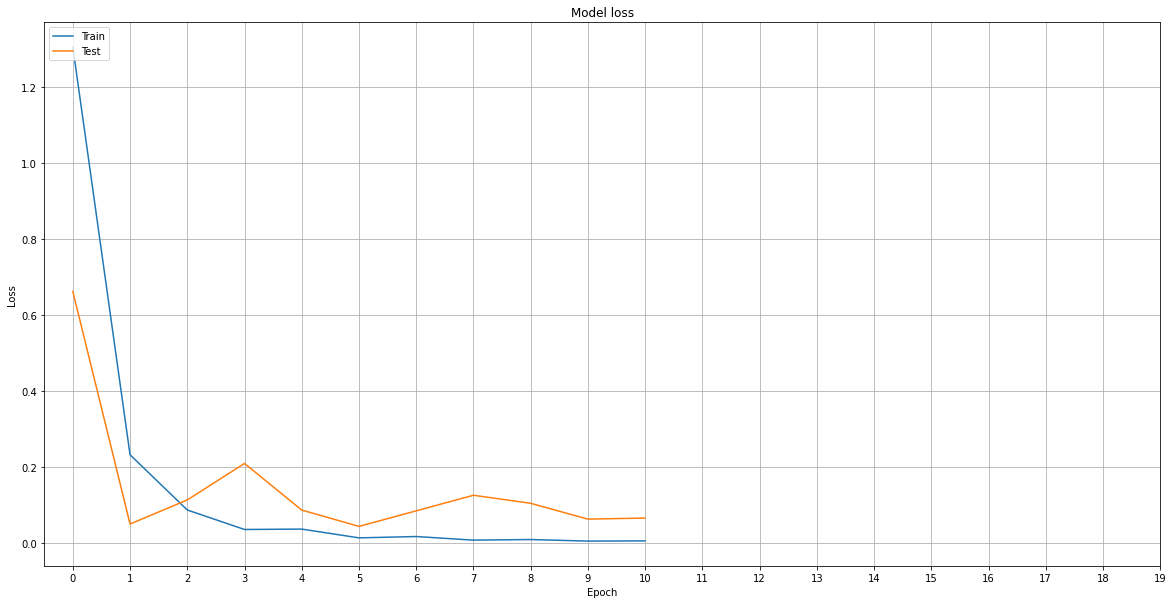

In [21]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 0.49
Mean Absolute Percentage Error (MAPE): 8.46 %
Median Absolute Percentage Error (MDAPE): 7.37 %


,MAE,MAPE,MDAPE
0,0.49051,8.461682,7.368775


In [23]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

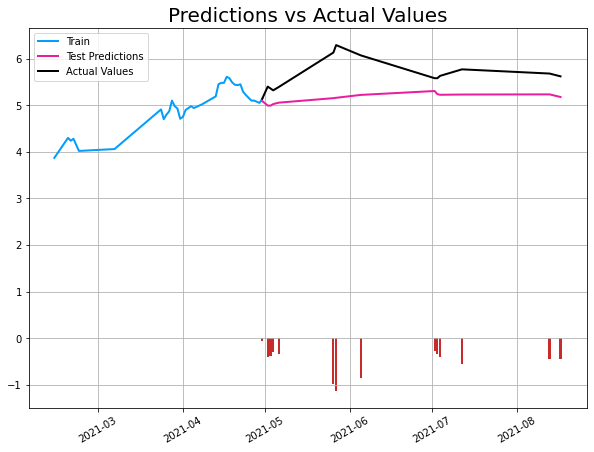

In [24]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 7-Day Shift

In [25]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Low', 'Volume', 'SD_log', 'Dir', '2D%Change', '7D%Change', '5Dir', 'Open', '4D%Change', 'Daily%Change', '6Dir', '4Dir', '3Dir', '7Dir', '2Dir', '3D%Change', '5D%Change', 'High', 'SD', '6D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,4Dir(t-7),3Dir(t-7),7Dir(t-7),2Dir(t-7),3D%Change(t-7),5D%Change(t-7),High(t-7),SD(t-7),6D%Change(t-7),Close(t-7)
13,4.20,4,9.0,14.0,23.0,60.869301,10.0,5.0,100.000000,14.0,...,0.0,1.0,1.0,1.0,0.501259,-0.742568,4.02,0.930101,3.084836,4.01
15,4.73,1,3.0,1.0,4.0,24.999375,3.0,1.5,50.000000,2.0,...,1.0,1.0,1.0,1.0,5.684762,2.506269,4.25,2.243312,1.237628,4.09
16,6.55,2,38.0,23.0,61.0,37.704856,41.0,20.5,100.000000,24.0,...,1.0,1.0,1.0,1.0,1.745628,3.816790,4.14,0.670677,2.255637,4.08
17,4.69,3,55.0,29.0,84.0,34.523768,93.0,46.5,1733.333333,52.0,...,1.0,1.0,1.0,1.0,3.768847,6.718352,4.19,1.247917,5.089060,4.13
18,4.56,4,23.0,9.0,32.0,28.124912,78.0,39.0,-39.473684,38.0,...,1.0,1.0,1.0,1.0,2.689478,4.738144,4.23,0.822854,8.527130,4.20


In [26]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-7)', 'comments_positive(t-7)', 'comment_count(t-7)', 'pct_pos_comments(t-7)', 'comments_neutral_rollsum_2D(t-7)', 'comments_neutral_rollmean_2D(t-7)', 'comments_neutral_2D_pctchg(t-7)', 'comments_positive_rollsum_2D(t-7)', 'comments_positive_rollmean_2D(t-7)', 'comments_positive_2D_pctchg(t-7)', 'comment_count_rollsum_2D(t-7)', 'comment_count_rollmean_2D(t-7)', 'comment_count_2D_pctchg(t-7)', 'pct_pos_comments_rollsum_2D(t-7)', 'pct_pos_comments_rollmean_2D(t-7)', 'pct_pos_comments_2D_pctchg(t-7)', 'comments_neutral_rollsum_3D(t-7)', 'comments_neutral_rollmean_3D(t-7)', 'comments_neutral_3D_pctchg(t-7)', 'comments_positive_rollsum_3D(t-7)', 'comments_positive_rollmean_3D(t-7)', 'comments_positive_3D_pctchg(t-7)', 'comment_count_rollsum_3D(t-7)', 'comment_count_rollmean_3D(t-7)', 'comment_count_3D_pctchg(t-7)', 'pct_pos_comments_rollsum_3D(t-7)', 'pct_pos_comments_rollmean_3D(t-7)', 'pct_pos_comments_3D_pctchg(t-7)', 'comments_ne

,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,4Dir(t-7),3Dir(t-7),7Dir(t-7),2Dir(t-7),3D%Change(t-7),5D%Change(t-7),High(t-7),SD(t-7),6D%Change(t-7),Close(t-7)
184,5.63,0,11.0,9.0,20.0,44.999775,35.0,17.5,100.000000,19.0,...,0.0,0.0,0.0,0.0,-2.430561,-4.906937,5.65,0.250358,-4.584041,5.62
186,5.43,2,2.0,2.0,4.0,49.998750,3.0,1.5,-81.818182,2.0,...,0.0,0.0,0.0,0.0,-4.634585,-7.118061,5.44,1.179067,-8.233277,5.35
187,5.45,3,1.0,1.0,2.0,49.997500,3.0,1.5,0.000000,3.0,...,0.0,0.0,0.0,0.0,-4.092527,-6.423617,5.48,0.567534,-6.423617,5.39
230,5.56,2,1.0,1.0,2.0,49.997500,1.0,0.5,100.000000,1.0,...,1.0,1.0,1.0,1.0,3.935595,2.288734,5.89,0.423923,1.751312,5.81
231,5.74,3,1.0,1.0,2.0,49.997500,2.0,1.0,100.000000,2.0,...,1.0,0.0,0.0,0.0,0.000000,1.610012,5.85,0.636839,0.000000,5.68


In [27]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)



(63, 100)
(22, 100)


In [28]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(56, 7, 99) (56,)
(15, 7, 99) (15,)
0.75
0.20146516499655776


In [29]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

693 7 99


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 2.0446
Epoch 1: val_loss improved from inf to 0.92761, saving model to NOK_Close_7shift_Sentiment.h5
4/4 [==============================] - 7s 770ms/step - loss: 2.0446 - val_loss: 0.9276
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 0.2052
Epoch 2: val_loss improved from 0.92761 to 0.05258, saving model to NOK_Close_7shift_Sentiment.h5
4/4 [==============================] - 2s 455ms/step - loss: 0.2052 - val_loss: 0.0526
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 0.0819
Epoch 3: val_loss did not improve from 0.05258
4/4 [==============================] - 1s 345ms/step - loss: 0.0819 - val_loss: 0.1227
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 0.0443
Epoch 4: val_loss did not improve from 0.05258
4/4 [==============================] - 1s 353ms/step - loss: 0.0443 - val_loss: 0.2291
Epoch 5/100
4/4 [==============================] - ETA: 0s - loss: 0.0

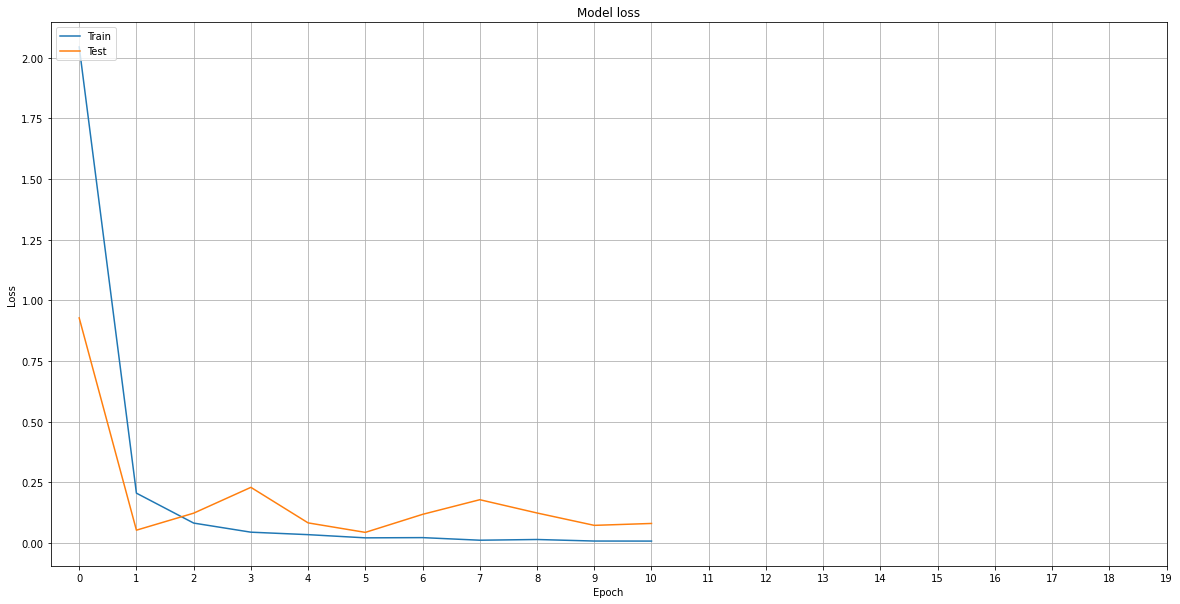

In [31]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 0.51
Mean Absolute Percentage Error (MAPE): 8.77 %
Median Absolute Percentage Error (MDAPE): 8.81 %


,MAE,MAPE,MDAPE
0,0.508587,8.768191,8.805782


In [33]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

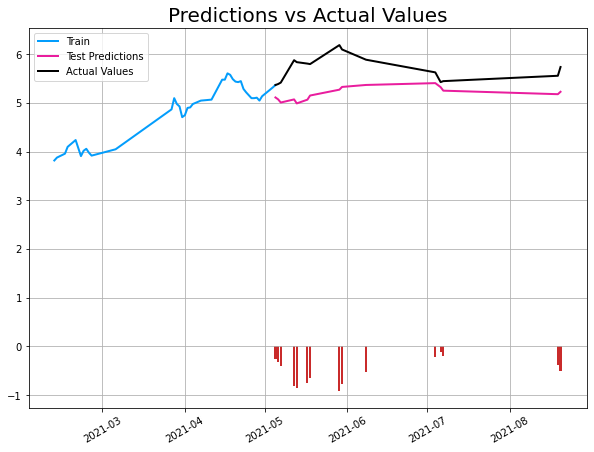

In [34]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

## LSTM: CLOSE PRICE WITHOUT SENTIMENT

### 1-Day Shift

In [35]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Low', 'Volume', 'SD_log', 'Dir', '2D%Change', '7D%Change', '5Dir', 'Open', '4D%Change', 'Daily%Change', '6Dir', '4Dir', '3Dir', '7Dir', '2Dir', '3D%Change', '5D%Change', 'High', 'SD', '6D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,4Dir(t-1),3Dir(t-1),7Dir(t-1),2Dir(t-1),3D%Change(t-1),5D%Change(t-1),High(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
9,4.08,4,1.0,1.0,0.5,100.0,1.0,0.333333,100.000000,1.0,...,1.0,1.0,1.0,1.0,5.684762,2.506269,4.25,2.243312,1.237628,4.09
10,4.13,1,1.0,3.0,1.5,-75.0,7.0,2.333333,-95.652174,30.0,...,1.0,1.0,1.0,1.0,1.745628,3.816790,4.14,0.670677,2.255637,4.08
11,4.20,2,4.0,5.0,2.5,100.0,7.0,2.333333,0.000000,11.0,...,1.0,1.0,1.0,1.0,3.768847,6.718352,4.19,1.247917,5.089060,4.13
12,4.22,3,61.0,65.0,32.5,6000.0,66.0,22.000000,2950.000000,68.0,...,1.0,1.0,1.0,1.0,2.689478,4.738144,4.23,0.822854,8.527130,4.20
13,4.20,4,84.0,145.0,72.5,2000.0,149.0,49.666667,8300.000000,150.0,...,1.0,1.0,1.0,1.0,3.431369,6.030145,4.23,0.180956,5.236896,4.22


In [36]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()


FEATURE LIST
['Close', 'day_of_week', 'comment_count(t-1)', 'comment_count_rollsum_2D(t-1)', 'comment_count_rollmean_2D(t-1)', 'comment_count_2D_pctchg(t-1)', 'comment_count_rollsum_3D(t-1)', 'comment_count_rollmean_3D(t-1)', 'comment_count_3D_pctchg(t-1)', 'comment_count_rollsum_4D(t-1)', 'comment_count_rollmean_4D(t-1)', 'comment_count_4D_pctchg(t-1)', 'comment_count_rollsum_5D(t-1)', 'comment_count_rollmean_5D(t-1)', 'comment_count_5D_pctchg(t-1)', 'comment_count_rollsum_6D(t-1)', 'comment_count_rollmean_6D(t-1)', 'comment_count_6D_pctchg(t-1)', 'comment_count_rollsum_7D(t-1)', 'comment_count_rollmean_7D(t-1)', 'comment_count_7D_pctchg(t-1)', 'is_meme(t-1)', 'Low(t-1)', 'Volume(t-1)', 'SD_log(t-1)', 'Dir(t-1)', '2D%Change(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Daily%Change(t-1)', '6Dir(t-1)', '4Dir(t-1)', '3Dir(t-1)', '7Dir(t-1)', '2Dir(t-1)', '3D%Change(t-1)', '5D%Change(t-1)', 'High(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']


,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,4Dir(t-1),3Dir(t-1),7Dir(t-1),2Dir(t-1),3D%Change(t-1),5D%Change(t-1),High(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
222,5.83,3,2.0,2.0,1.0,100.0,2.0,0.666667,100.0,2.0,...,0.0,0.0,0.0,1.0,0.000000,-0.350877,5.74,0.621744,-1.899830,5.68
223,5.81,4,3.0,5.0,2.5,100.0,5.0,1.666667,100.0,5.0,...,1.0,1.0,1.0,1.0,4.293377,2.101574,5.84,0.785859,2.280704,5.83
227,5.55,4,2.0,4.0,2.0,100.0,4.0,1.333333,100.0,4.0,...,0.0,0.0,1.0,1.0,-0.860580,1.408458,5.78,0.318107,3.041146,5.76
229,5.60,1,1.0,1.0,0.5,100.0,1.0,0.333333,100.0,1.0,...,0.0,0.0,0.0,0.0,-1.748250,-3.270225,5.66,0.482640,-3.602059,5.62
233,5.69,0,1.0,2.0,1.0,100.0,2.0,0.666667,100.0,2.0,...,1.0,1.0,0.0,1.0,1.071428,1.981976,5.76,0.587225,-1.736118,5.66


In [37]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(101, 43)
(32, 43)


In [38]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(94, 7, 42) (94,)
(25, 7, 42) (25,)
0.5
0.9999999999999998


In [39]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

294 7 42


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.1252
Epoch 1: val_loss improved from inf to 0.14371, saving model to NOK_Close_1shift_Baseline.h5
6/6 [==============================] - 6s 307ms/step - loss: 0.1252 - val_loss: 0.1437
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.0408
Epoch 2: val_loss improved from 0.14371 to 0.02757, saving model to NOK_Close_1shift_Baseline.h5
6/6 [==============================] - 1s 102ms/step - loss: 0.0408 - val_loss: 0.0276
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.0214
Epoch 3: val_loss did not improve from 0.02757
6/6 [==============================] - 0s 74ms/step - loss: 0.0214 - val_loss: 0.0381
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.0186
Epoch 4: val_loss improved from 0.02757 to 0.00891, saving model to NOK_Close_1shift_Baseline.h5
6/6 [==============================] - 1s 94ms/step - loss: 0.0186 - val_loss: 0.0089
Epoch 5/100
6/6 [=======

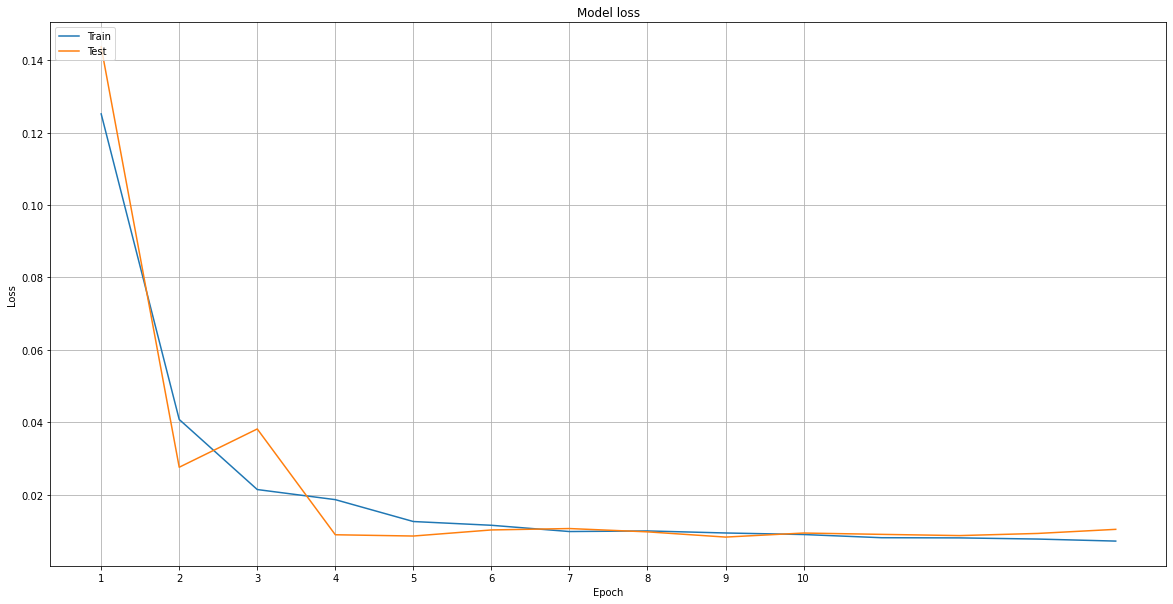

In [41]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [42]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 0.19
Mean Absolute Percentage Error (MAPE): 3.37 %
Median Absolute Percentage Error (MDAPE): 1.99 %


,MAE,MAPE,MDAPE
0,0.193243,3.374893,1.989648


In [43]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

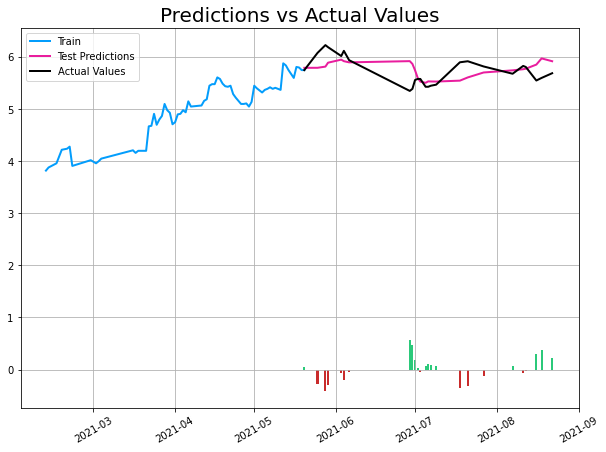

In [44]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 4-Day Shift

In [45]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Low', 'Volume', 'SD_log', 'Dir', '2D%Change', '7D%Change', '5Dir', 'Open', '4D%Change', 'Daily%Change', '6Dir', '4Dir', '3Dir', '7Dir', '2Dir', '3D%Change', '5D%Change', 'High', 'SD', '6D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,4Dir(t-4),3Dir(t-4),7Dir(t-4),2Dir(t-4),3D%Change(t-4),5D%Change(t-4),High(t-4),SD(t-4),6D%Change(t-4),Close(t-4)
10,4.13,1,23.0,24.0,12.0,100.000000,24.0,8.000000,100.000000,24.0,...,0.0,1.0,1.0,1.0,0.501259,-0.742568,4.02,0.930101,3.084836,4.01
11,4.20,2,4.0,27.0,13.5,300.000000,28.0,9.333333,100.000000,28.0,...,0.0,1.0,1.0,1.0,1.272263,-1.485147,3.98,0.696090,-1.485147,3.98
12,4.22,3,2.0,6.0,3.0,-91.304348,29.0,9.666667,100.000000,30.0,...,1.0,1.0,1.0,1.0,5.684762,2.506269,4.25,2.243312,1.237628,4.09
13,4.20,4,1.0,3.0,1.5,-75.000000,7.0,2.333333,-95.652174,30.0,...,1.0,1.0,1.0,1.0,1.745628,3.816790,4.14,0.670677,2.255637,4.08
14,4.85,0,84.0,145.0,72.5,2000.000000,149.0,49.666667,8300.000000,150.0,...,1.0,1.0,1.0,1.0,3.768847,6.718352,4.19,1.247917,5.089060,4.13


In [46]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comment_count(t-4)', 'comment_count_rollsum_2D(t-4)', 'comment_count_rollmean_2D(t-4)', 'comment_count_2D_pctchg(t-4)', 'comment_count_rollsum_3D(t-4)', 'comment_count_rollmean_3D(t-4)', 'comment_count_3D_pctchg(t-4)', 'comment_count_rollsum_4D(t-4)', 'comment_count_rollmean_4D(t-4)', 'comment_count_4D_pctchg(t-4)', 'comment_count_rollsum_5D(t-4)', 'comment_count_rollmean_5D(t-4)', 'comment_count_5D_pctchg(t-4)', 'comment_count_rollsum_6D(t-4)', 'comment_count_rollmean_6D(t-4)', 'comment_count_6D_pctchg(t-4)', 'comment_count_rollsum_7D(t-4)', 'comment_count_rollmean_7D(t-4)', 'comment_count_7D_pctchg(t-4)', 'is_meme(t-4)', 'Low(t-4)', 'Volume(t-4)', 'SD_log(t-4)', 'Dir(t-4)', '2D%Change(t-4)', '7D%Change(t-4)', '5Dir(t-4)', 'Open(t-4)', '4D%Change(t-4)', 'Daily%Change(t-4)', '6Dir(t-4)', '4Dir(t-4)', '3Dir(t-4)', '7Dir(t-4)', '2Dir(t-4)', '3D%Change(t-4)', '5D%Change(t-4)', 'High(t-4)', 'SD(t-4)', '6D%Change(t-4)', 'Close(t-4)']


,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,4Dir(t-4),3Dir(t-4),7Dir(t-4),2Dir(t-4),3D%Change(t-4),5D%Change(t-4),High(t-4),SD(t-4),6D%Change(t-4),Close(t-4)
224,5.68,0,3.0,5.0,2.5,100.0,5.0,1.666667,100.0,5.0,...,0.0,0.0,0.0,0.0,-2.101574,-3.454228,5.63,0.252508,-4.607508,5.59
228,5.62,0,2.0,4.0,2.0,100.0,4.0,1.333333,100.0,4.0,...,1.0,0.0,0.0,0.0,0.000000,1.610012,5.85,0.636839,0.000000,5.68
232,5.66,4,1.0,1.0,0.5,100.0,1.0,0.333333,100.0,1.0,...,0.0,0.0,0.0,0.0,-1.748250,-3.270225,5.66,0.482640,-3.602059,5.62
235,5.86,2,1.0,1.0,0.5,100.0,1.0,0.333333,100.0,1.0,...,1.0,1.0,1.0,1.0,2.135229,-0.347230,5.79,0.563015,0.349650,5.74
236,5.99,3,1.0,2.0,1.0,100.0,2.0,0.666667,100.0,2.0,...,1.0,1.0,0.0,1.0,1.071428,1.981976,5.76,0.587225,-1.736118,5.66


In [47]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(93, 43)
(30, 43)


In [48]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(86, 7, 42) (86,)
(23, 7, 42) (23,)
0.75
0.3186813340365371


In [49]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

294 7 42


In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.1387
Epoch 1: val_loss improved from inf to 0.04323, saving model to NOK_Close_4shift_Baseline.h5
6/6 [==============================] - 6s 300ms/step - loss: 0.1387 - val_loss: 0.0432
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.0318
Epoch 2: val_loss improved from 0.04323 to 0.00900, saving model to NOK_Close_4shift_Baseline.h5
6/6 [==============================] - 1s 96ms/step - loss: 0.0318 - val_loss: 0.0090
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.0198
Epoch 3: val_loss did not improve from 0.00900
6/6 [==============================] - 0s 73ms/step - loss: 0.0198 - val_loss: 0.0155
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.0101
Epoch 4: val_loss did not improve from 0.00900
6/6 [==============================] - 0s 67ms/step - loss: 0.0101 - val_loss: 0.0119
Epoch 5/100
6/6 [==============================] - ETA: 0s - loss: 0.0102
E

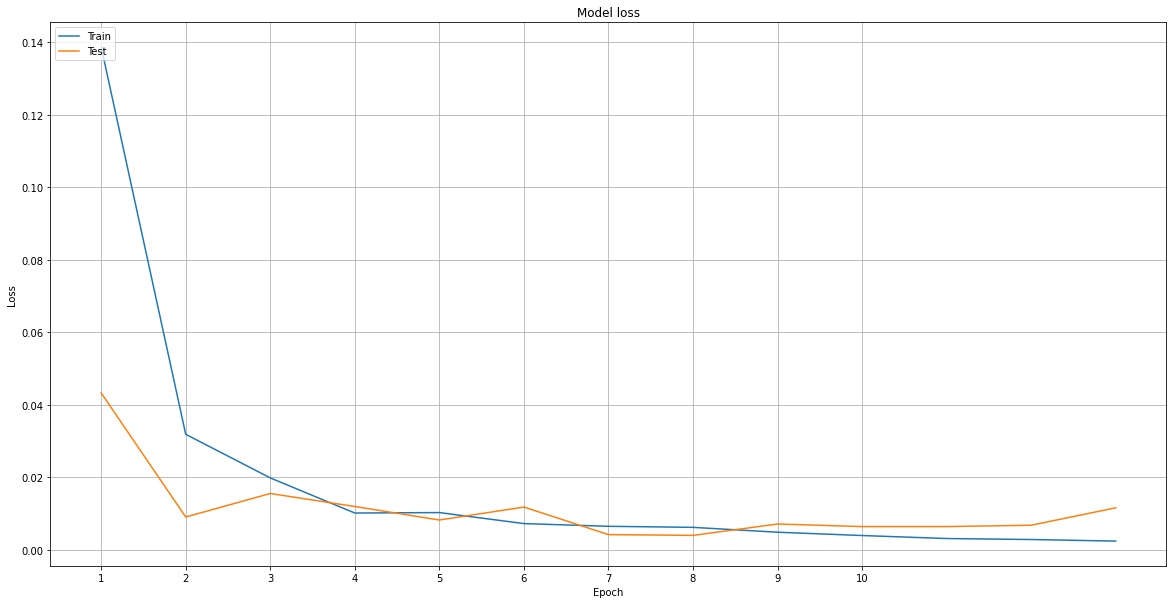

In [51]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [52]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 0.14
Mean Absolute Percentage Error (MAPE): 2.47 %
Median Absolute Percentage Error (MDAPE): 1.96 %


,MAE,MAPE,MDAPE
0,0.142105,2.466842,1.958581


In [53]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

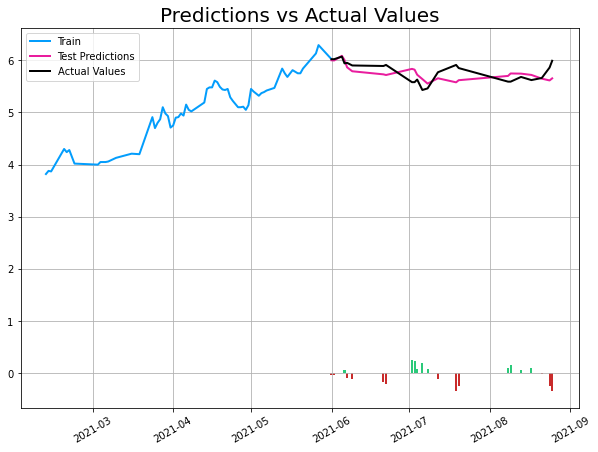

In [54]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 7-Day Shift

In [55]:
bdep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['Low', 'Volume', 'SD_log', 'Dir', '2D%Change', '7D%Change', '5Dir', 'Open', '4D%Change', 'Daily%Change', '6Dir', '4Dir', '3Dir', '7Dir', '2Dir', '3D%Change', '5D%Change', 'High', 'SD', '6D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,4Dir(t-7),3Dir(t-7),7Dir(t-7),2Dir(t-7),3D%Change(t-7),5D%Change(t-7),High(t-7),SD(t-7),6D%Change(t-7),Close(t-7)
13,4.20,4,23.0,24.0,12.0,100.0,24.0,8.000000,100.000000,24.0,...,0.0,1.0,1.0,1.0,0.501259,-0.742568,4.02,0.930101,3.084836,4.01
14,4.85,0,1.0,3.0,1.5,-75.0,7.0,2.333333,-95.652174,30.0,...,0.0,1.0,1.0,1.0,1.272263,-1.485147,3.98,0.696090,-1.485147,3.98
15,4.73,1,4.0,5.0,2.5,100.0,7.0,2.333333,0.000000,11.0,...,1.0,1.0,1.0,1.0,5.684762,2.506269,4.25,2.243312,1.237628,4.09
16,6.55,2,61.0,65.0,32.5,6000.0,66.0,22.000000,2950.000000,68.0,...,1.0,1.0,1.0,1.0,1.745628,3.816790,4.14,0.670677,2.255637,4.08
17,4.69,3,84.0,145.0,72.5,2000.0,149.0,49.666667,8300.000000,150.0,...,1.0,1.0,1.0,1.0,3.768847,6.718352,4.19,1.247917,5.089060,4.13


In [56]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comment_count(t-7)', 'comment_count_rollsum_2D(t-7)', 'comment_count_rollmean_2D(t-7)', 'comment_count_2D_pctchg(t-7)', 'comment_count_rollsum_3D(t-7)', 'comment_count_rollmean_3D(t-7)', 'comment_count_3D_pctchg(t-7)', 'comment_count_rollsum_4D(t-7)', 'comment_count_rollmean_4D(t-7)', 'comment_count_4D_pctchg(t-7)', 'comment_count_rollsum_5D(t-7)', 'comment_count_rollmean_5D(t-7)', 'comment_count_5D_pctchg(t-7)', 'comment_count_rollsum_6D(t-7)', 'comment_count_rollmean_6D(t-7)', 'comment_count_6D_pctchg(t-7)', 'comment_count_rollsum_7D(t-7)', 'comment_count_rollmean_7D(t-7)', 'comment_count_7D_pctchg(t-7)', 'is_meme(t-7)', 'Low(t-7)', 'Volume(t-7)', 'SD_log(t-7)', 'Dir(t-7)', '2D%Change(t-7)', '7D%Change(t-7)', '5Dir(t-7)', 'Open(t-7)', '4D%Change(t-7)', 'Daily%Change(t-7)', '6Dir(t-7)', '4Dir(t-7)', '3Dir(t-7)', '7Dir(t-7)', '2Dir(t-7)', '3D%Change(t-7)', '5D%Change(t-7)', 'High(t-7)', 'SD(t-7)', '6D%Change(t-7)', 'Close(t-7)']


,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,4Dir(t-7),3Dir(t-7),7Dir(t-7),2Dir(t-7),3D%Change(t-7),5D%Change(t-7),High(t-7),SD(t-7),6D%Change(t-7),Close(t-7)
223,5.81,4,1.0,3.0,1.5,100.0,3.0,1.000000,100.0,3.0,...,0.0,0.0,1.0,0.0,-1.213175,-1.213175,5.82,0.653288,2.517983,5.70
226,5.76,2,2.0,2.0,1.0,100.0,2.0,0.666667,100.0,2.0,...,0.0,0.0,0.0,0.0,-1.929819,-4.607508,5.63,0.632209,-3.119581,5.59
230,5.56,2,2.0,2.0,1.0,100.0,2.0,0.666667,100.0,2.0,...,1.0,1.0,1.0,1.0,3.935595,2.288734,5.89,0.423923,1.751312,5.81
231,5.74,3,2.0,4.0,2.0,100.0,4.0,1.333333,100.0,4.0,...,1.0,0.0,0.0,0.0,0.000000,1.610012,5.85,0.636839,0.000000,5.68
233,5.69,0,1.0,1.0,0.5,100.0,1.0,0.333333,100.0,1.0,...,0.0,0.0,1.0,1.0,-0.860580,1.408458,5.78,0.318107,3.041146,5.76


In [57]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(104, 43)
(33, 43)


In [58]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])


(97, 7, 42) (97,)
(26, 7, 42) (26,)
0.25
0.26007333684935197


In [59]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

294 7 42


In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
6/7 [========================>.....] - ETA: 0s - loss: 0.1078
Epoch 1: val_loss improved from inf to 0.07775, saving model to NOK_Close_7shift_Baseline.h5
7/7 [==============================] - 6s 266ms/step - loss: 0.1069 - val_loss: 0.0777
Epoch 2/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0239
Epoch 2: val_loss improved from 0.07775 to 0.01123, saving model to NOK_Close_7shift_Baseline.h5
7/7 [==============================] - 1s 88ms/step - loss: 0.0242 - val_loss: 0.0112
Epoch 3/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0161
Epoch 3: val_loss did not improve from 0.01123
7/7 [==============================] - 0s 68ms/step - loss: 0.0162 - val_loss: 0.0190
Epoch 4/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0162
Epoch 4: val_loss did not improve from 0.01123
7/7 [==============================] - 1s 75ms/step - loss: 0.0162 - val_loss: 0.0160
Epoch 5/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0074
E

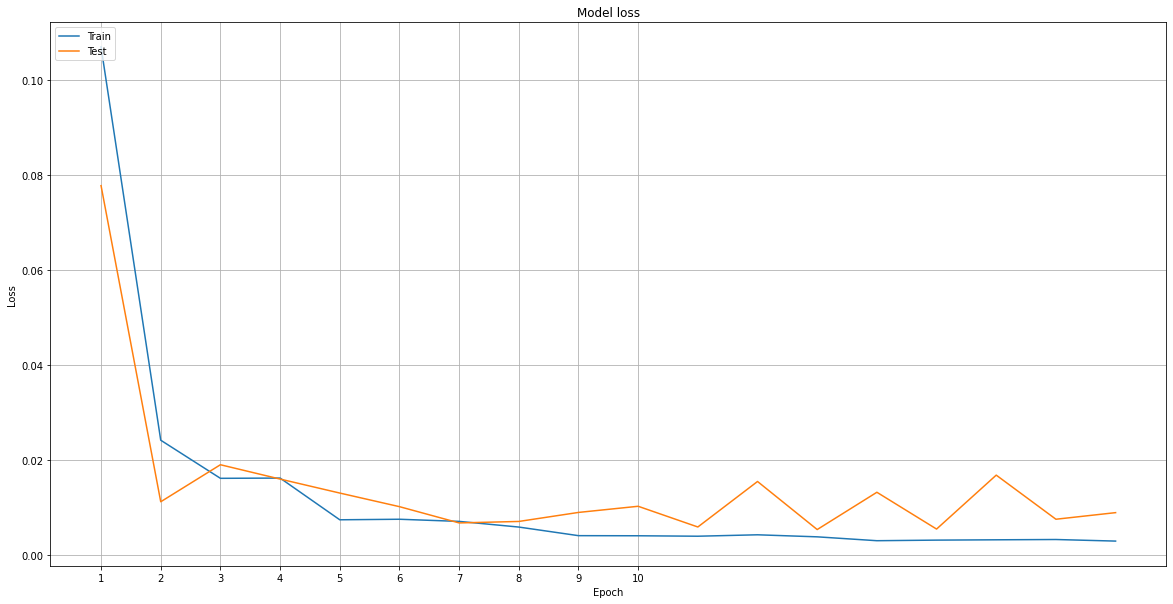

In [61]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [62]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 0.16
Mean Absolute Percentage Error (MAPE): 2.84 %
Median Absolute Percentage Error (MDAPE): 2.17 %


,MAE,MAPE,MDAPE
0,0.163374,2.841443,2.165666


In [63]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

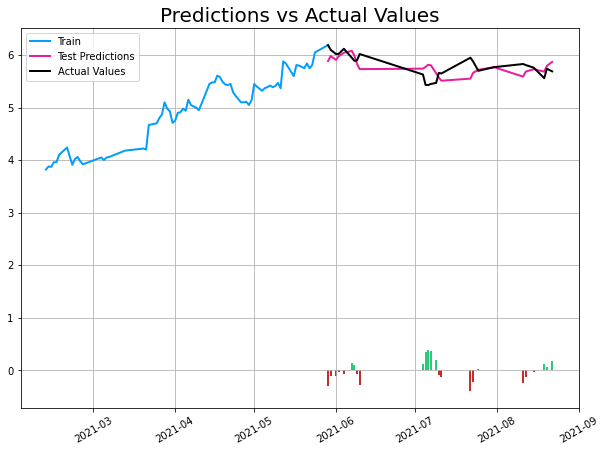

In [64]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

## Overall Results

In [65]:
results_df =pd.DataFrame.from_dict(results_dict).transpose().reset_index()
results_df['ticker'] = results_df['index'].str.split('_').str[0]
results_df['shift'] = results_df['index'].str.split('_').str[1]
results_df['metric'] = results_df['index'].str.split('_').str[2]
results_df['scenario'] = results_df['index'].str.split('_').str[3]
results_df['scenario'].fillna(value = 'sentiment', inplace = True)
results_df['results_%'] = results_df[0]
results_df.drop(['index', 0], axis = 1, inplace = True)
results_df.sort_values(['metric', 'shift','scenario'], inplace = True)
results_df = results_df.pivot(index = ['shift', 'metric'], columns = 'scenario', values = 'results_%').reset_index()
results_df

scenario,shift,metric,baseline,sentiment
0,1dayshift,MAE,0.193243,0.287605
1,1dayshift,MAPE,3.374893,5.037762
2,1dayshift,MDAPE,1.989648,4.107401
3,4dayshift,MAE,0.142105,0.490510
4,4dayshift,MAPE,2.466842,8.461682
5,4dayshift,MDAPE,1.958581,7.368775
6,7dayshift,MAE,0.163374,0.508587
7,7dayshift,MAPE,2.841443,8.768191
8,7dayshift,MDAPE,2.165666,8.805782


In [66]:
results_df.to_csv('{}_LSTM.csv'.format(ticker), index = False)